![](./questions.jpeg)

In [ ]:
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
customers_columns = ["Customer ID", "Customer Name", "Activation Date", "Current Status"]
transactions_columns = ["Interaction ID", "Time Spent on Site", "Purchase Amount", "Customer ID"]

In [ ]:
customers = pd.read_csv("customers.csv", usecols=customers_columns)
transactions = pd.read_csv("transactions.csv", usecols=transactions_columns)

In [ ]:
customers.head()

,Customer ID,Customer Name,Activation Date,Current Status
0,1000,Bill Floyd,2020-01-05,Gold
1,1001,Jason Fritz,2022-03-29,Bronze
2,1002,Melissa Flynn,2020-11-28,Gold
3,1003,Aaron Mills,2022-11-14,Gold
4,1004,Kristi Barton,2021-06-21,Bronze


In [ ]:
def clean_text(txt):
    txt = txt.strip()
    txt = re.sub(r"\s+", "_", txt)
    txt = txt.lower()
    return txt

In [ ]:
customers_columns

['Customer ID', 'Customer Name', 'Activation Date', 'Current Status']

In [ ]:
customers_columns = [clean_text(column) for column in customers_columns]
transactions_columns = [clean_text(column) for column in transactions_columns]

In [ ]:
customers_columns

['customer_id', 'customer_name', 'activation_date', 'current_status']

In [ ]:
customers.columns = customers_columns
transactions.columns = transactions_columns

In [ ]:
customers.head()

,customer_id,customer_name,activation_date,current_status
0,1000,Bill Floyd,2020-01-05,Gold
1,1001,Jason Fritz,2022-03-29,Bronze
2,1002,Melissa Flynn,2020-11-28,Gold
3,1003,Aaron Mills,2022-11-14,Gold
4,1004,Kristi Barton,2021-06-21,Bronze


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      5000 non-null   int64 
 1   customer_name    5000 non-null   object
 2   activation_date  5000 non-null   object
 3   current_status   5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [ ]:
customers["activation_date"] = pd.to_datetime(customers.activation_date)

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      5000 non-null   int64         
 1   customer_name    5000 non-null   object        
 2   activation_date  5000 non-null   datetime64[ns]
 3   current_status   5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.4+ KB


In [ ]:
transactions.head()

,interaction_id,time_spent_on_site,purchase_amount,customer_id
0,4479095440-1000,19.157810,481.330172,1000
1,4479095472-1000,21.088000,505.451138,1000
2,4479095504-1000,20.047809,399.693529,1000
3,4479095536-1000,21.108193,380.090676,1000
4,4479095568-1000,21.030607,432.649775,1000


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233763 entries, 0 to 233762
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   interaction_id      233763 non-null  object 
 1   time_spent_on_site  233763 non-null  float64
 2   purchase_amount     233763 non-null  float64
 3   customer_id         233763 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 7.1+ MB


## Sanity checks

### Customer data

#### customer id has to be unique

In [ ]:
customers.shape

(5000, 4)

In [ ]:
customers.customer_id.nunique() == customers.shape[0]

True

#### are there any null values?

In [ ]:
customers.isna().sum()

customer_id        0
customer_name      0
activation_date    0
current_status     0
dtype: int64

### Transaction data

#### interaction_id has to be unique 

In [ ]:
transactions.interaction_id.nunique() == transactions.shape[0]

True

#### all customer_ids in transaction data have to be in customer data

In [ ]:
set(transactions.customer_id) == set(customers.customer_id)

True

#### are there are any null values?

In [ ]:
transactions.isna().sum()

interaction_id        0
time_spent_on_site    0
purchase_amount       0
customer_id           0
dtype: int64

## EDA

### Customers data

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      5000 non-null   int64         
 1   customer_name    5000 non-null   object        
 2   activation_date  5000 non-null   datetime64[ns]
 3   current_status   5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.4+ KB


#### What is the range of activation date?

In [ ]:
customers.activation_date.min(), customers.activation_date.max(), customers.activation_date.max() - customers.activation_date.min() 

(Timestamp('2019-12-07 00:00:00'),
 Timestamp('2022-12-06 00:00:00'),
 Timedelta('1095 days 00:00:00'))

#### making sure there is no bias in source data (for activation_date)

(array([737425., 737546., 737669., 737791., 737911., 738034., 738156.,
        738276., 738399., 738521.]),
 <a list of 10 Text major ticklabel objects>)

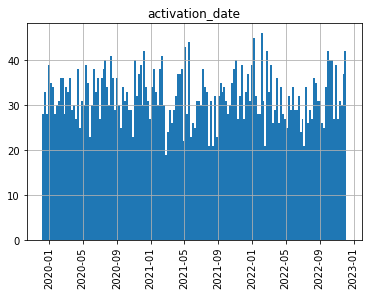

In [ ]:
ax = customers.hist("activation_date", bins=156)
plt.xticks(rotation = 90)

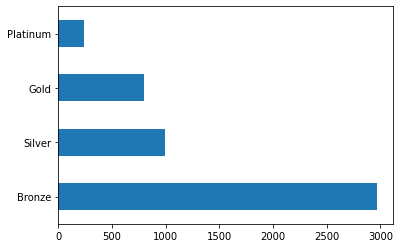

In [ ]:
customers.current_status.value_counts().plot(kind="barh")

### Transactions data

In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233763 entries, 0 to 233762
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   interaction_id      233763 non-null  object 
 1   time_spent_on_site  233763 non-null  float64
 2   purchase_amount     233763 non-null  float64
 3   customer_id         233763 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 7.1+ MB


#### time_spent_on_site

In [ ]:
print("(min, max): ", transactions.time_spent_on_site.min(), transactions.time_spent_on_site.max())
print("range: ", transactions.time_spent_on_site.max() - transactions.time_spent_on_site.min())

(min, max):  15.423353622268024 24.37915165285658
range:  8.955798030588557


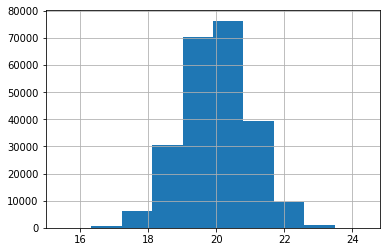

In [ ]:
transactions.time_spent_on_site.hist()

In [ ]:
transactions.time_spent_on_site.describe()

count    233763.000000
mean         20.002156
std           0.999653
min          15.423354
25%          19.328641
50%          20.000443
75%          20.674769
max          24.379152
Name: time_spent_on_site, dtype: float64

#### purchase_amount

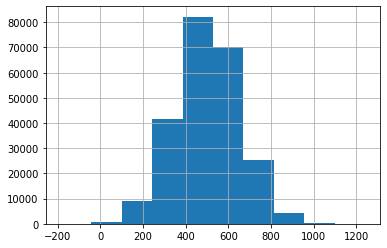

In [ ]:
transactions.purchase_amount.hist()

In [ ]:
transactions.purchase_amount.describe()

count    233763.000000
mean        500.392722
std         150.087326
min        -186.051552
25%         399.187578
50%         500.508585
75%         601.454433
max        1241.386682
Name: purchase_amount, dtype: float64

## let's join!

In [ ]:
df = pd.merge(customers, transactions, on="customer_id", how="inner")

In [ ]:
df.head()

,customer_id,customer_name,activation_date,current_status,interaction_id,time_spent_on_site,purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,4479095440-1000,19.157810,481.330172
1,1000,Bill Floyd,2020-01-05,Gold,4479095472-1000,21.088000,505.451138
2,1000,Bill Floyd,2020-01-05,Gold,4479095504-1000,20.047809,399.693529
3,1000,Bill Floyd,2020-01-05,Gold,4479095536-1000,21.108193,380.090676
4,1000,Bill Floyd,2020-01-05,Gold,4479095568-1000,21.030607,432.649775


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233763 entries, 0 to 233762
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         233763 non-null  int64         
 1   customer_name       233763 non-null  object        
 2   activation_date     233763 non-null  datetime64[ns]
 3   current_status      233763 non-null  object        
 4   interaction_id      233763 non-null  object        
 5   time_spent_on_site  233763 non-null  float64       
 6   purchase_amount     233763 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 14.3+ MB


In [ ]:
df.describe()

,customer_id,time_spent_on_site,purchase_amount
count,233763.000000,233763.000000,233763.000000
mean,3494.988779,20.002156,500.392722
std,1455.456497,0.999653,150.087326
min,1000.000000,15.423354,-186.051552
25%,2229.000000,19.328641,399.187578
50%,3516.000000,20.000443,500.508585
75%,4757.000000,20.674769,601.454433
max,5999.000000,24.379152,1241.386682


In [ ]:
df.customer_id.nunique() == df.shape[0]

False

## customer_name and interaction_id are not useful for prediction

In [ ]:
df = df.drop(columns=["customer_name",  "interaction_id"])

In [ ]:
df.head()

,customer_id,activation_date,current_status,time_spent_on_site,purchase_amount
0,1000,2020-01-05,Gold,19.157810,481.330172
1,1000,2020-01-05,Gold,21.088000,505.451138
2,1000,2020-01-05,Gold,20.047809,399.693529
3,1000,2020-01-05,Gold,21.108193,380.090676
4,1000,2020-01-05,Gold,21.030607,432.649775


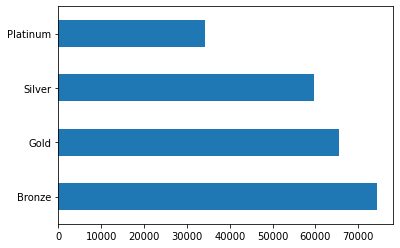

In [ ]:
df.current_status.value_counts().plot(kind="barh")

In [ ]:
customers.current_status.value_counts()

Bronze      2970
Silver       997
Gold         796
Platinum     237
Name: current_status, dtype: int64

In [ ]:
237/2970

0.0797979797979798

In [ ]:
df.current_status.value_counts()

Bronze      74422
Gold        65531
Silver      59568
Platinum    34242
Name: current_status, dtype: int64

In [ ]:
34242/74422

0.46010588266910324

In [ ]:
34242/237

144.48101265822785

In [ ]:
74422/2970

25.057912457912458

* customer data
    * platinum:gold:silver:bronze

* joined df
    * platinum:gold:silver:bronze

since the class imbalance has reduced, we can see that platinum customers may have higher number of transactions compared to bronze

## Feature Engineering

In [ ]:
######### Average purchase amount
def get_avg_purchase_amount(customer_purchase_amount):
    return customer_purchase_amount.mean()


########## purchase amount value categories

_, pa_mean, pa_std, pa_min, _, _, _, pa_max = transactions.purchase_amount.describe()
return_pa = [pa_min, 0]
very_low_pa = [0, pa_mean - 2*pa_std]
low_pa = [pa_mean - 2*pa_std, pa_mean - pa_std]
moderate_pa = [pa_mean - pa_std, pa_mean + pa_std]
high_pa = [pa_mean + pa_std, pa_mean + 2*pa_std]
very_high_pa = [pa_mean + 2*pa_std, pa_max]

def get_return_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(return_pa[0], return_pa[1])
    return pa_counts.sum()

def get_very_low_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(very_low_pa[0], very_low_pa[1])
    return pa_counts.sum()

def get_low_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(low_pa[0], low_pa[1])
    return pa_counts.sum()

def get_moderate_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(moderate_pa[0], moderate_pa[1])
    return pa_counts.sum()

def get_high_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(high_pa[0], high_pa[1])
    return pa_counts.sum()

def get_very_high_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(very_high_pa[0], very_high_pa[1])
    return pa_counts.sum()


### Average time spent
def get_avg_time_spent(customer_times):
    return customer_times.mean()




In [ ]:
customer_features = customers.copy()

In [ ]:
customer_features.head()

,customer_id,customer_name,activation_date,current_status
0,1000,Bill Floyd,2020-01-05,Gold
1,1001,Jason Fritz,2022-03-29,Bronze
2,1002,Melissa Flynn,2020-11-28,Gold
3,1003,Aaron Mills,2022-11-14,Gold
4,1004,Kristi Barton,2021-06-21,Bronze


In [ ]:
def add_ft_col(df, ft_series, primary_key, ft_name, how="left"):
    ft_df = ft_series.reset_index()
    ft_df.columns = [primary_key, ft_name]

    return pd.merge(df,
                    ft_df,
                    on=primary_key,
                    how=how
                    )

### Average Purchase Amount

In [ ]:
avg_pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_avg_purchase_amount)

customer_features = add_ft_col(customer_features, avg_pa_ft, "customer_id", "avg_purchase_amount")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,489.418153
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385
3,1003,Aaron Mills,2022-11-14,Gold,513.988916
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715


### Number of times purchase amount value (return, low, very low, moderate, high, very_high)

In [ ]:
num_ret_ft = df.groupby("customer_id")["purchase_amount"].apply(get_return_pa_count)

customer_features = add_ft_col(customer_features, num_ret_ft, "customer_id", "num_returns")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_very_low_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_very_low")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0,2
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0,1
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0,4
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0,2
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0,0


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_low_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_low")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low,num_low
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0,2,10
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0,1,5
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0,4,9
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0,2,4
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0,0,3


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_moderate_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_moderate")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low,num_low,num_moderate
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0,2,10,62
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0,1,5,21
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0,4,9,45
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0,2,4,53
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0,0,3,17


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_high_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_high")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0,2,10,62,8
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0,1,5,21,2
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0,4,9,45,18
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0,2,4,53,9
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0,0,3,17,3


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_very_high_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_very_high")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0,2,10,62,8,0
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0,1,5,21,2,0
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0,4,9,45,18,2
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0,2,4,53,9,1
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0,0,3,17,3,1


### Average Time Spent

In [ ]:
ft_series = df.groupby("customer_id")["time_spent_on_site"].apply(get_avg_time_spent)

customer_features = add_ft_col(customer_features, ft_series, "customer_id", "avg_time_spent")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high,avg_time_spent
0,1000,Bill Floyd,2020-01-05,Gold,489.418153,0,2,10,62,8,0,20.148738
1,1001,Jason Fritz,2022-03-29,Bronze,485.492337,0,1,5,21,2,0,19.871985
2,1002,Melissa Flynn,2020-11-28,Gold,527.366385,0,4,9,45,18,2,20.003110
3,1003,Aaron Mills,2022-11-14,Gold,513.988916,0,2,4,53,9,1,19.845271
4,1004,Kristi Barton,2021-06-21,Bronze,519.072715,0,0,3,17,3,1,19.518252


## Index target column to numeric

In [ ]:
le = LabelEncoder()
customer_features["current_status"] = le.fit_transform(customer_features["current_status"])

In [ ]:
le.inverse_transform([0, 1, 2, 3]).tolist()

['Bronze', 'Gold', 'Platinum', 'Silver']

In [ ]:
customer_features.head()

,customer_id,customer_name,activation_date,current_status,avg_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high,avg_time_spent
0,1000,Bill Floyd,2020-01-05,1,489.418153,0,2,10,62,8,0,20.148738
1,1001,Jason Fritz,2022-03-29,0,485.492337,0,1,5,21,2,0,19.871985
2,1002,Melissa Flynn,2020-11-28,1,527.366385,0,4,9,45,18,2,20.003110
3,1003,Aaron Mills,2022-11-14,1,513.988916,0,2,4,53,9,1,19.845271
4,1004,Kristi Barton,2021-06-21,0,519.072715,0,0,3,17,3,1,19.518252


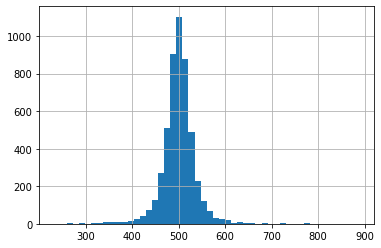

In [ ]:
customer_features.avg_purchase_amount.hist(bins=50)

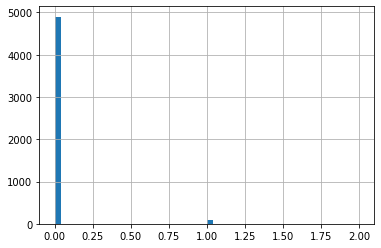

In [ ]:
customer_features.num_returns.hist(bins=50)

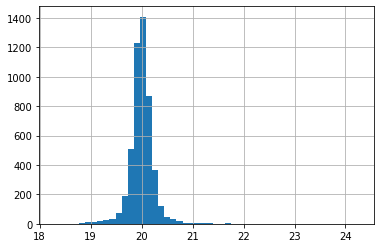

In [ ]:
customer_features.avg_time_spent.hist(bins=50)

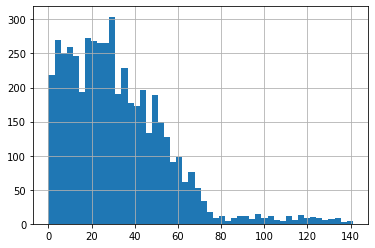

In [ ]:
customer_features.num_moderate.hist(bins=50)

## Modeling

### Data

In [ ]:
feature_columns = ["avg_purchase_amount", "avg_time_spent", "num_returns", "num_very_low", "num_low", "num_moderate", "num_high", "num_very_high"]
target_column = "current_status"
X = customer_features[feature_columns]
y = customer_features[target_column]


### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
y_test = le.inverse_transform(y_test)

### Model

#### Random Forest

In [ ]:
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)
y_pred_rf = le.inverse_transform(y_pred_rf)

In [ ]:
target_values = le.inverse_transform([0, 1, 2, 3])

In [ ]:
target_values

array(['Bronze', 'Gold', 'Platinum', 'Silver'], dtype=object)

In [ ]:
cm_numpy = confusion_matrix(y_test, y_pred_rf, )
df_cm = pd.DataFrame(cm_numpy, index = [f"Actual: {i}" for i in target_values],
                  columns = [f"Predicted: {i}" for i in target_values])
df_cm["Total"] = df_cm.T.sum()
df_cm

,Predicted: Bronze,Predicted: Gold,Predicted: Platinum,Predicted: Silver,Total
Actual: Bronze,953,0,0,27,980
Actual: Gold,0,216,0,47,263
Actual: Platinum,0,10,68,0,78
Actual: Silver,55,36,0,238,329


In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_rf)
performance_df = pd.DataFrame({"precision": precision.tolist(),
                                "recall": recall.tolist(),
                                "f1": f1.tolist()
                                })
performance_df = performance_df.reset_index()
performance_df.columns = ["class", "precision", "recall", "f1"]
performance_df["class"] = le.inverse_transform(performance_df["class"])
performance_df

,class,precision,recall,f1
0,Bronze,0.945437,0.972449,0.958753
1,Gold,0.824427,0.821293,0.822857
2,Platinum,1.000000,0.871795,0.931507
3,Silver,0.762821,0.723404,0.742590


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))

Accuracy:  0.8939393939393939


#### Decision Tree

In [ ]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt = clf.predict(X_test)
y_pred_dt = le.inverse_transform(y_pred_dt)

In [ ]:
cm_numpy = confusion_matrix(y_test, y_pred_dt )
df_cm = pd.DataFrame(cm_numpy, index = [f"Actual: {i}" for i in target_values],
                  columns = [f"Predicted: {i}" for i in target_values])
df_cm["Total"] = df_cm.T.sum()
df_cm

,Predicted: Bronze,Predicted: Gold,Predicted: Platinum,Predicted: Silver,Total
Actual: Bronze,939,0,0,41,980
Actual: Gold,0,215,6,42,263
Actual: Platinum,0,7,71,0,78
Actual: Silver,59,64,0,206,329


In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_dt)
performance_df = pd.DataFrame({"precision": precision.tolist(),
                                "recall": recall.tolist(),
                                "f1": f1.tolist()
                                })
performance_df = performance_df.reset_index()
performance_df.columns = ["class", "precision", "recall", "f1"]
performance_df["class"] = le.inverse_transform(performance_df["class"])
performance_df

,class,precision,recall,f1
0,Bronze,0.940882,0.958163,0.949444
1,Gold,0.751748,0.817490,0.783242
2,Platinum,0.922078,0.910256,0.916129
3,Silver,0.712803,0.626140,0.666667
